# Notebook Description

In this notebook, I attempt to use machine learning to predict whether or not a golfer will make the cut at the Masters Tournament. The models used take inputs consisting of full season aggregate statistics from the previous year to make the predictions for that year's Masters Tournament (e.g., the models used 2018 full season data to predict 2019 results.

Additionally, we will use the subset of golfers that make the cut to attempt to predict the top 10 come Sunday evening at Augusta using the same inputs as before.

# Necessary Packages and Libraries

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# webscrapping
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup

# sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# class imbalance
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# graphing
%matplotlib inline
sns.set_style('darkgrid')
figsize = (13,5)

# Helper Functions

## Webscrapping

In [2]:
# PGATour.com Webscrapping Function
def get_PGA_Tour_data(stats, seasons):

    """
    This function pings the PGA Tour's server and gathers the desired statistics
    (by inserting the stat_id into the url) and appends it to our data container
    """

    data = []
    
    for season in seasons:  
        print(f"Beginning {season} season:")
        for stat in stats: 
            url = f"https://www.pgatour.com/content/pgatour/stats/stat.{stat['stat_id']}.y{season}.html"

            #opening up connection, grabbing the page
            uClient = uReq(url)
            page_html = uClient.read()

            #html parsing using BeautifulSoup
            page_soup = soup(page_html, 'html.parser')

            #find the table where stats are kept
            tbody = page_soup.find('tbody')

            #each golfer is separated by a <tr> tag
            raw_golfers = tbody.findAll('tr')

            #loop through each golfer, grab name and avg. distance
            for raw_golfer in raw_golfers:
                golfer = {}
                golfer['season'] = season            
                name = raw_golfer.find('td', {'class':'player-name'}).a.text
                golfer['full_name'] = name.replace(' ', '_').lower()
                golfer[f"{stat['stat_name']}"] = raw_golfer.find('td', {'class':None}).text
                data.append(golfer)
            print(f" {stat['stat_name']} stats added for the {season} season")
        print(f"{season} season completed.\n")

    #close the client
    uClient.close()

    return data

## Convert Strings to Feet

In [3]:
# Convert stats to feet function
def convert_to_feet(x):
    """
    This function takes in a string and returns an integer
    """
    
    if type(x) == str:
        y = x.replace("'","").replace('"',"").split()

        if len(y) == 1:
            y.extend([0])
            for i in range(len(y)):
                y[i] = int(y[i])
            return y[0]+(y[1]/12)

        else:
            for i in range(len(y)):
                y[i] = int(y[i])
            return y[0]+(y[1]/12)

    else:
        return np.nan

## Format Golfer

In [4]:
# Format golfer names from results Dataframe
def format_golfer(x):
    return x.replace(' ','_').lower()

## Plotter Functions

### Confusion Matrix Plotter

In [5]:
# creates the confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure(figsize=(5,4));
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")


    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

### Feature Importance Plotter

In [6]:
# creates feature importance graphs
def plot_feature_importances(X_train, model, n_features):
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

# Data Gathering and Cleaning

## Data Gathering

### Desired Features

In [7]:
# The stat_id will be inserted into the url for each ping
stats = [
    {'stat_name': 'drive_distance', # goes back to 1980
     'stat_id': '101'},
    {'stat_name': 'drive_accuracy', # goes back to 1980
     'stat_id': '102'},
    {'stat_name': 'gir', # goes back to 1980
     'stat_id': '103'},
    {'stat_name': 'proximity', # goes back to 2002
     'stat_id': '331'},
    {'stat_name': 'scrambling', # goes back to 1992 
     'stat_id': '130'},
    {'stat_name': 'putting_conversion', # goes back to 1980
     'stat_id': '115'},
    {'stat_name': 'putting_rating',
     'stat_id': '02428'},
    {'stat_name': 'sg_off_tee', # goes back to 2004
     'stat_id': '02567'},
    {'stat_name': 'sg_approach', # goes back to 2004
     'stat_id': '02568'},
    {'stat_name': 'sg_around_green', # goes back to 2004
     'stat_id': '02569'},
    {'stat_name': 'sg_putting', # goes back to 2004
     'stat_id': '02564'}
]

### Seasons Considered

In [8]:
# Consider 2002-2019 for none strokes_gained data and 2004 for strokes_gained data
seasons = range(2004, 2020)

### Webscrapping and Dataframe Conversion

In [10]:
# Call the web scrapping helper function defined above. Save the results and examine Dataframe
data = get_PGA_Tour_data(stats, seasons)

Beginning 2004 season:


AttributeError: 'NoneType' object has no attribute 'findAll'

In [ ]:
# Convert data to Dataframe and save raw data locally
df = pd.DataFrame(data)
df.to_csv('raw_golfer_data.csv')

In [ ]:
# sg_data = get_PGA_Tour_data(stats, seasons)
# sg_df = pd.DataFrame(sg_data)
# sg_df.to_csv('raw_golfer_data_sg.csv')

## Data Cleaning

### Convert Features

In [19]:
# Import and Examine Raw Data
df = pd.read_csv('raw_golfer_data.csv', index_col=0)
df = df.reset_index(drop=True)
df.head()

,season,full_name,drive_distance,gir,proximity,scrambling,putting_conversion
0,2002,john_daly,306.8,NaN,NaN,NaN,NaN
1,2002,boo_weekley,297.0,NaN,NaN,NaN,NaN
2,2002,mathew_goggin,296.1,NaN,NaN,NaN,NaN
3,2002,charles_howell_iii,293.7,NaN,NaN,NaN,NaN
4,2002,dennis_paulson,293.7,NaN,NaN,NaN,NaN


In [20]:
# Convert proximity to feet integers
df['proximity'] = df['proximity'].apply(lambda x: convert_to_feet(x))

In [21]:
# Convert percentage features to decimals
df['gir'] = df['gir']/100
df['scrambling'] = df['scrambling']/100
df['putting_conversion'] = df['putting_conversion']/100

### Groupby Season and Golfer

In [22]:
# Group stats by season and golfer
df = df.groupby(['season', 'full_name'])[
    'drive_distance',
    'gir',
    'proximity',
    'scrambling',
    'putting_conversion'
].mean()

"""
    'drive_distance',
    'drive_accuracy',
    'gir',
    'proximity',
    'scrambling',
    'putting_conversion',
    'putting_rating',
    'sg_off_tee',
    'sg_approach',
    'sg_around_green',
    'sg_putting'
"""

# Save grouped data locally
df.to_csv('golfer_data.csv')

In [23]:
# Reload and examine new dataframe
df = pd.read_csv('golfer_data.csv')

print(df.shape)
df.head()

(3428, 7)


,season,full_name,drive_distance,gir,proximity,scrambling,putting_conversion
0,2002,andrew_magee,282.9,0.6345,36.500000,0.6097,0.2947
1,2002,bart_bryant,275.2,0.6970,33.916667,0.5972,0.2869
2,2002,ben_crane,286.1,0.6273,36.750000,0.5913,0.3407
3,2002,bernhard_langer,271.3,0.6400,34.916667,0.6204,0.2743
4,2002,billy_andrade,279.8,0.6389,35.833333,0.6023,0.3336


### Holdout Set

In [24]:
# Create holdout set of 2019 data. Holdout set will be used for predicting 2020 Masters results
holdout = df[df['season'] == 2019]
df = df[df['season'] != 2019]

# Examine holdout and dataframe
print(f"Holdout Set: {holdout.shape}")
print(f"Validation Set: {df.shape}")

# Overwrite grouped data and save both the holdout set and grouped dataframe locally
holdout.to_csv('holdout_data.csv')
df.to_csv('golfer_data.csv')

Holdout Set: (188, 7)
Validation Set: (3240, 7)


### Incorporate Historical Tournament Data

#### Generate the Field

In [25]:
# Load Masters Results data and format each golfer to match our data's format
masters_results = pd.read_csv('masters_results - data.csv')
masters_results['golfer'] = masters_results['golfer'].apply(lambda x: format_golfer(x))

print(masters_results.shape)
masters_results.head()

(1587, 5)


,season,golfer,total_score,make_cut,top_10
0,2003,len_mattiace,281,1,1
1,2003,mike_weir,281,1,1
2,2003,phil_mickelson,283,1,1
3,2003,jim_furyk,284,1,1
4,2003,jeff_maggert,286,1,1


In [26]:
# Generate the field for each year from 2003-2019
fields = []
seasons = range(2003, 2020)

for season in seasons:
    field = masters_results[masters_results['season'] == season].golfer.tolist()
    fields.append(field)

In [27]:
# Generate a list of golfers we have stats for from 2002-2018
golfers_universe = []
seasons = range(2002, 2019)

for season in seasons:
    golfer = df[df['season'] == season].full_name.tolist()
    golfers_universe.append(golfer)

In [28]:
# Generate 1 or 0 depending on if golfer played in the Masters the next year
in_field = []

for index, golfers in enumerate(golfers_universe):
    for golfer in golfers:
        if golfer in fields[index]:
            in_field.append(1)
        else:
            in_field.append(0)

df['in_field'] = in_field

#### Dropping Golfers

In [29]:
# Drop the golfers that did not play in the Masters
df = df[df['in_field'] != 0]

# Drop 'in_feild' column since all golfers are now 1. Reset index
df.drop('in_field', axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

# Save clean data locally by ovewriting current csv
df.to_csv('golfer_data.csv')

# Generate Target Variables

## Made Cut

Create a target variable called 'made_cut', which take on a value of 1 if the golfer made the cut in the following year's Masters Tournament and 0 if not.

In [30]:
# Reload and examine dataframe
df = pd.read_csv('golfer_data.csv', index_col=0)

print(df.shape)
df.head()

(989, 7)


,season,full_name,drive_distance,gir,proximity,scrambling,putting_conversion
0,2002,bernhard_langer,271.3,0.6400,34.916667,0.6204,0.2743
1,2002,billy_mayfair,270.9,0.6649,35.833333,0.6108,0.2700
2,2002,bob_estes,279.8,0.7015,32.000000,0.5964,0.2846
3,2002,brad_faxon,269.6,0.6372,34.083333,0.6144,0.3077
4,2002,chad_campbell,281.5,0.6916,31.500000,0.5983,0.2937


In [31]:
# Generate the golfers that made the cut each year from 2003-2019
golfers_that_made_cut = []
seasons = range(2003, 2020)

for season in seasons:
    weekenders = masters_results[(masters_results['season'] == season) &
                                (masters_results['make_cut'] == 1)].golfer.tolist()
    golfers_that_made_cut.append(weekenders)

In [32]:
# Generate a list of golfers we have stats for from 2002-2018
golfers_universe = []
seasons = range(2002, 2019)

for season in seasons:
    golfer = df[df['season'] == season].full_name.tolist()
    golfers_universe.append(golfer)

In [33]:
# Generate 1 or 0 depending on if golfer made the cut at the Masters the next year
made_cut = []

for index, golfers in enumerate(golfers_universe):
    for golfer in golfers:
        if golfer in golfers_that_made_cut[index]:
            made_cut.append(1)
        else:
            made_cut.append(0)

df['made_cut'] = made_cut

## Top 10

Create a target variable called 'top_10', which take on a value of 1 if the golfer made the cut in the following year's Masters Tournament and 0 if not.

In [34]:
# Generate the golfers that made the cut each year from 2003-2019
golfers_that_made_top10 = []
seasons = range(2003, 2020)

for season in seasons:
    weekenders = masters_results[(masters_results['season'] == season) &
                                (masters_results['top_10'] == 1)].golfer.tolist()
    golfers_that_made_top10.append(weekenders)

In [35]:
# Generate a list of golfers we have stats for from 2002-2018
golfers_universe = []
seasons = range(2002, 2019)

for season in seasons:
    golfer = df[df['season'] == season].full_name.tolist()
    golfers_universe.append(golfer)

In [36]:
# Generate 1 or 0 depending on if golfer played in the Masters the next year
top_10 = []

for index, golfers in enumerate(golfers_universe):
    for golfer in golfers:
        if golfer in golfers_that_made_top10[index]:
            top_10.append(1)
        else:
            top_10.append(0)

df['top_10'] = top_10

In [37]:
# Save final df locally and overwrite current csv
df.to_csv('golfers_final.csv')

# Exploratory Data Analysis

In [38]:
# Import Dataframe
df = pd.read_csv('golfers_final.csv', index_col=0)

print(df.shape)
df.head()

(989, 9)


,season,full_name,drive_distance,gir,proximity,scrambling,putting_conversion,made_cut,top_10
0,2002,bernhard_langer,271.3,0.6400,34.916667,0.6204,0.2743,0,0
1,2002,billy_mayfair,270.9,0.6649,35.833333,0.6108,0.2700,1,0
2,2002,bob_estes,279.8,0.7015,32.000000,0.5964,0.2846,1,0
3,2002,brad_faxon,269.6,0.6372,34.083333,0.6144,0.3077,1,0
4,2002,chad_campbell,281.5,0.6916,31.500000,0.5983,0.2937,0,0


## General Information

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 0 to 988
Data columns (total 9 columns):
season                989 non-null int64
full_name             989 non-null object
drive_distance        989 non-null float64
gir                   989 non-null float64
proximity             989 non-null float64
scrambling            989 non-null float64
putting_conversion    989 non-null float64
made_cut              989 non-null int64
top_10                989 non-null int64
dtypes: float64(5), int64(3), object(1)
memory usage: 77.3+ KB


In [40]:
df.drop(['season', 'made_cut', 'top_10'],axis=1).describe()

,drive_distance,gir,proximity,scrambling,putting_conversion
count,989.000000,989.000000,989.000000,989.000000,989.000000
mean,291.089080,0.660310,35.157904,0.589053,0.298922
std,9.412093,0.026968,1.595981,0.032884,0.022904
min,264.000000,0.543300,29.583333,0.483000,0.222700
25%,284.200000,0.642800,34.166667,0.567400,0.283800
50%,291.000000,0.661000,35.166667,0.590200,0.298800
75%,297.400000,0.679000,36.166667,0.611900,0.313900
max,319.700000,0.741500,40.416667,0.696700,0.373900


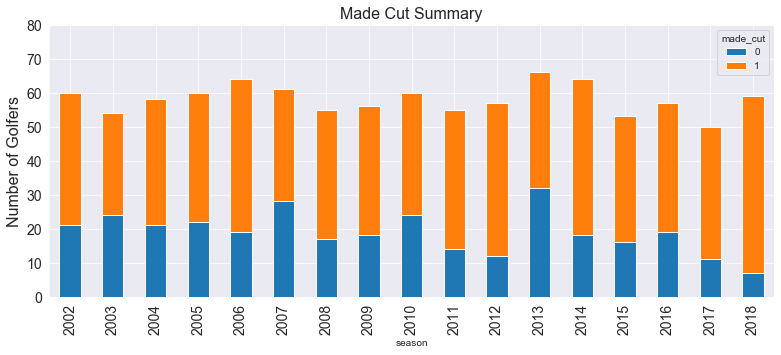

In [41]:
target_variable = 'made_cut'
title = target_variable.replace('_', ' ').title()

fig = plt.figure(figsize=figsize);
ax = fig.add_subplot(111);
ax.set_title(f'{title} Summary', {'fontsize' : 16})
ax.set_ylabel('Number of Golfers', {'fontsize' : 16});
ax.set_ylim(0, 80);

df.groupby(['season',target_variable]).size().unstack().plot.bar(
    stacked=True,
    ax=ax,
    fontsize=14
);

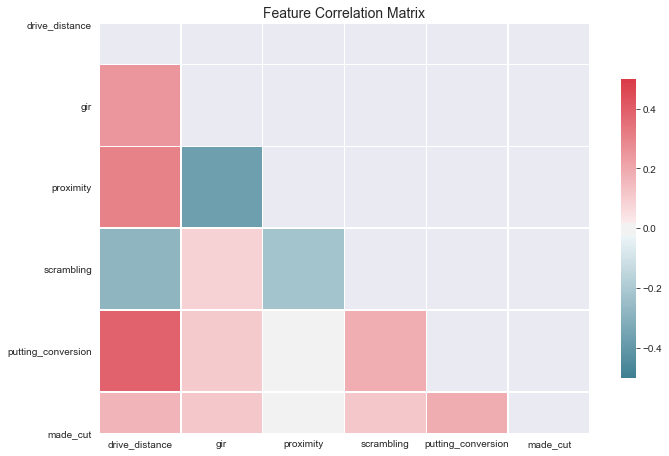

In [42]:
df_corr = df.drop(['season', 'full_name', 'top_10'], axis=1)

fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(111)

#create mask
mask = np.zeros_like(df_corr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#create color scheme
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(df_corr.corr(),
            mask=mask, 
            cmap=cmap,
            center=0,
            vmin=-0.5,
            vmax=0.5,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5},
            ax=ax);

ax.set_title("Feature Correlation Matrix", {'fontsize' : 14});

## Visualizations by Feature

### Driving Distance

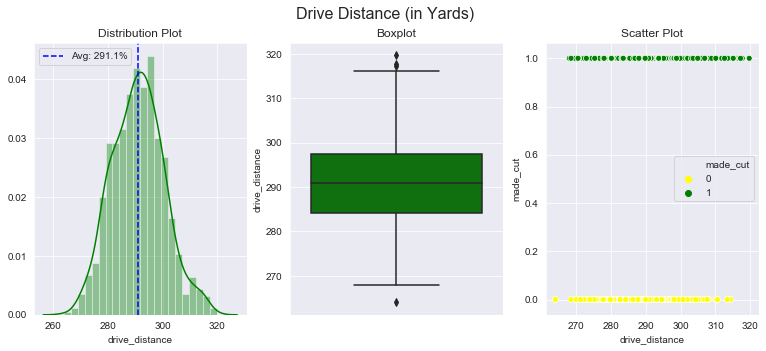

In [43]:
feature = 'drive_distance'
title = feature.replace('_', ' ').title()
mean = round(df[feature].mean(), 1)

fig = plt.figure(figsize=figsize);
fig.suptitle(f"{title} (in Yards)", fontsize=16);

ax1 = fig.add_subplot(131);
sns.distplot(df[feature], bins='auto', color='g', ax=ax1);
ax1.axvline(mean, linestyle='--', color='blue', label=f'Avg: {mean}%');
ax1.set_title('Distribution Plot');
ax1.legend();

ax2 = fig.add_subplot(132);
sns.boxplot(df[feature], orient='v', color='g');
ax2.set_title('Boxplot');

ax2 = fig.add_subplot(133);
sns.scatterplot(df[feature], df['made_cut'], hue=df['made_cut'], palette=['yellow', 'green']);
ax2.set_title('Scatter Plot');

### Greens in Regulation

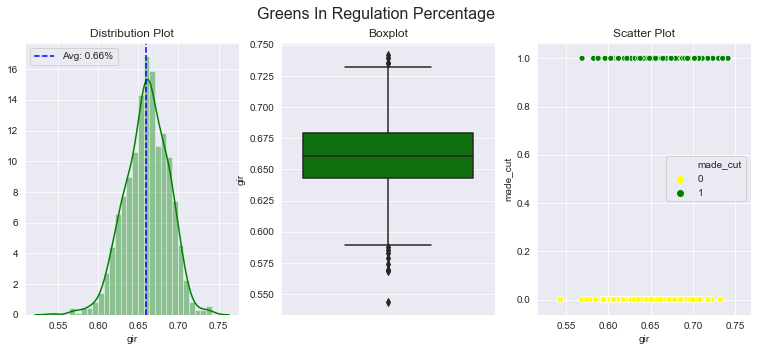

In [44]:
feature = 'gir'
title = 'Greens In Regulation'
mean = round(df[feature].mean(), 3)

fig = plt.figure(figsize=figsize);
fig.suptitle(f"{title} Percentage", fontsize=16);

ax1 = fig.add_subplot(131);
sns.distplot(df[feature], bins='auto', color='g', ax=ax1);
ax1.axvline(mean, linestyle='--', color='blue', label=f'Avg: {mean}%');
ax1.set_title('Distribution Plot');
ax1.legend();

ax2 = fig.add_subplot(132);
sns.boxplot(df[feature], orient='v', color='g');
ax2.set_title('Boxplot');

ax2 = fig.add_subplot(133);
sns.scatterplot(df[feature], df['made_cut'], hue=df['made_cut'], palette=['yellow', 'green']);
ax2.set_title('Scatter Plot');

### Scrambling

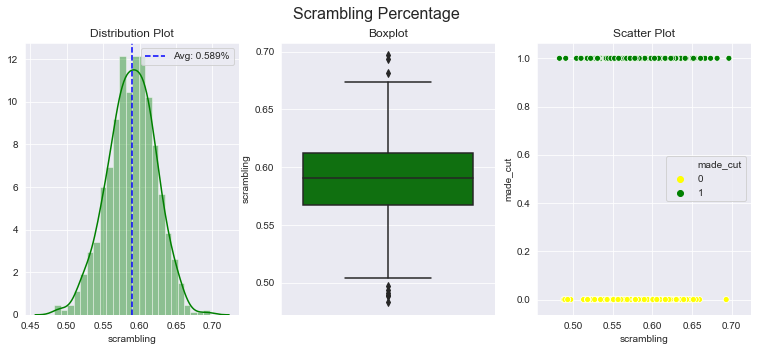

In [45]:
feature = 'scrambling'
title = feature.title()
mean = round(df[feature].mean(), 3)

fig = plt.figure(figsize=figsize);
fig.suptitle(f"{title} Percentage", fontsize=16);

ax1 = fig.add_subplot(131);
sns.distplot(df[feature], bins='auto', color='g', ax=ax1);
ax1.axvline(mean, linestyle='--', color='blue', label=f'Avg: {mean}%');
ax1.set_title('Distribution Plot');
ax1.legend();

ax2 = fig.add_subplot(132);
sns.boxplot(df[feature], orient='v', color='g');
ax2.set_title('Boxplot');

ax2 = fig.add_subplot(133);
sns.scatterplot(df[feature], df['made_cut'], hue=df['made_cut'], palette=['yellow', 'green']);
ax2.set_title('Scatter Plot');

### Putting Conversion

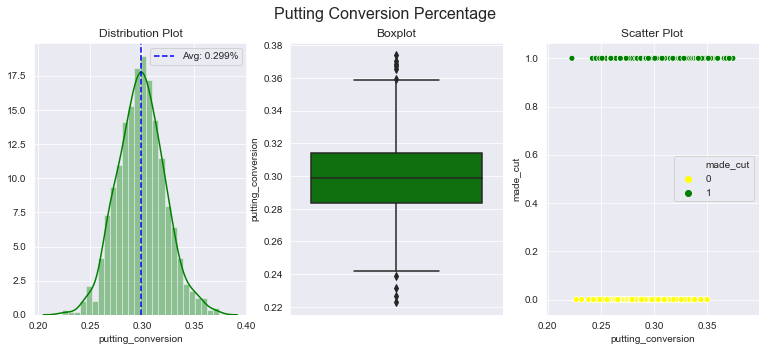

In [46]:
feature = 'putting_conversion'
title = feature.replace('_', ' ').title()
mean = round(df[feature].mean(), 3)

fig = plt.figure(figsize=figsize);
fig.suptitle(f"{title} Percentage", fontsize=16);

ax1 = fig.add_subplot(131);
sns.distplot(df[feature], bins='auto', color='g', ax=ax1);
ax1.axvline(mean, linestyle='--', color='blue', label=f'Avg: {mean}%');
ax1.set_title('Distribution Plot');
ax1.legend();

ax2 = fig.add_subplot(132);
sns.boxplot(df[feature], orient='v', color='g');
ax2.set_title('Boxplot');

ax2 = fig.add_subplot(133);
sns.scatterplot(df[feature], df['made_cut'], hue=df['made_cut'], palette=['yellow', 'green']);
ax2.set_title('Scatter Plot');

# Feature Engineering and Additional EDA

## On the Green Area

Generate a circle where the radius equals a golfer's average proximity to the hole after his appraoch shot

In [49]:
df['on_the_green_area'] = df['proximity']**2 * np.pi

,season,full_name,drive_distance,gir,proximity,scrambling,putting_conversion,made_cut,top_10,on_the_green_area
0,2002,bernhard_langer,271.3,0.6400,34.916667,0.6204,0.2743,0,0,3830.146860
1,2002,billy_mayfair,270.9,0.6649,35.833333,0.6108,0.2700,1,0,4033.892234
2,2002,bob_estes,279.8,0.7015,32.000000,0.5964,0.2846,1,0,3216.990877
3,2002,brad_faxon,269.6,0.6372,34.083333,0.6144,0.3077,1,0,3649.505283
4,2002,chad_campbell,281.5,0.6916,31.500000,0.5983,0.2937,0,0,3117.245311


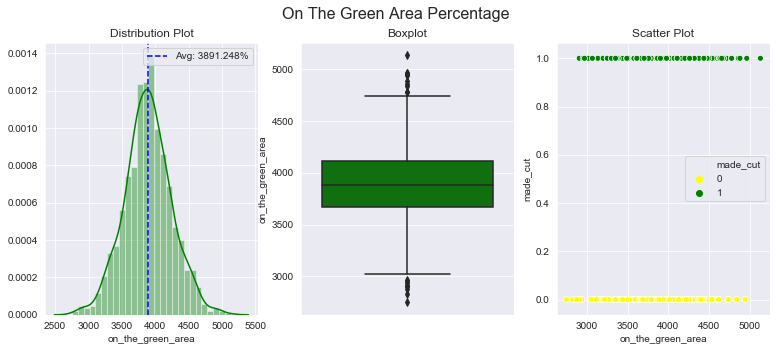

In [51]:
feature = 'on_the_green_area'
title = feature.replace('_', ' ').title()
mean = round(df[feature].mean(), 3)

fig = plt.figure(figsize=figsize);
fig.suptitle(f"{title} (in Feet Squared)", fontsize=16);

ax1 = fig.add_subplot(131);
sns.distplot(df[feature], bins='auto', color='g', ax=ax1);
ax1.axvline(mean, linestyle='--', color='blue', label=f'Avg: {mean}%');
ax1.set_title('Distribution Plot');
ax1.legend();

ax2 = fig.add_subplot(132);
sns.boxplot(df[feature], orient='v', color='g');
ax2.set_title('Boxplot');

ax2 = fig.add_subplot(133);
sns.scatterplot(df[feature], df['made_cut'], hue=df['made_cut'], palette=['yellow', 'green']);
ax2.set_title('Scatter Plot');

## Par or Better Area

Generate a circle that represents a circle in which a golfer will make a par or better from

In [58]:
df['par_or_better_dist'] = np.sqrt((df['on_the_green_area']*df['putting_conversion'])/np.pi)

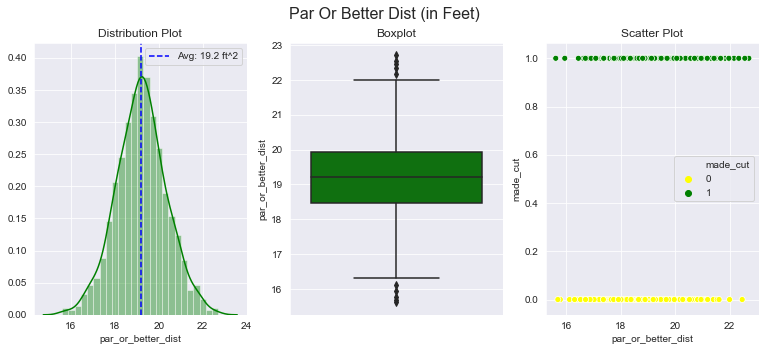

In [60]:
feature = 'par_or_better_dist'
title = feature.replace('_', ' ').title()
mean = round(df[feature].mean(), 1)

fig = plt.figure(figsize=figsize);
fig.suptitle(f"{title} (in Feet)", fontsize=16);

ax1 = fig.add_subplot(131);
sns.distplot(df[feature], bins='auto', color='g', ax=ax1);
ax1.axvline(mean, linestyle='--', color='blue', label=f'Avg: {mean} ft^2');
ax1.set_title('Distribution Plot');
ax1.legend();

ax2 = fig.add_subplot(132);
sns.boxplot(df[feature], orient='v', color='g');
ax2.set_title('Boxplot');

ax2 = fig.add_subplot(133);
sns.scatterplot(df[feature], df['made_cut'], hue=df['made_cut'], palette=['yellow', 'green']);
ax2.set_title('Scatter Plot');

In [66]:
df.columns

Index(['season', 'full_name', 'drive_distance', 'gir', 'proximity',
       'scrambling', 'putting_conversion', 'made_cut', 'top_10',
       'on_the_green_area', 'par_or_better_dist'],
      dtype='object')

In [65]:
df.drop('landing_area', axis=1, inplace=True)

In [67]:
cols = ['season', 'full_name', 'drive_distance', 'gir', 'proximity',
       'scrambling', 'putting_conversion', 'made_cut', 'top_10',
       'on_the_green_area', 'par_or_better_dist']

df = df[cols]

In [68]:
df.to_csv('golfers_final.csv')

# Modeling

## Load Data

In [93]:
df = pd.read_csv('golfers_final.csv', index_col=0)

print(df.shape)
df.head()

(989, 11)


,season,full_name,drive_distance,gir,proximity,scrambling,putting_conversion,made_cut,top_10,on_the_green_area,par_or_better_dist
0,2002,bernhard_langer,271.3,0.6400,34.916667,0.6204,0.2743,0,0,3830.146860,18.287135
1,2002,billy_mayfair,270.9,0.6649,35.833333,0.6108,0.2700,1,0,4033.892234,18.619546
2,2002,bob_estes,279.8,0.7015,32.000000,0.5964,0.2846,1,0,3216.990877,17.071333
3,2002,brad_faxon,269.6,0.6372,34.083333,0.6144,0.3077,1,0,3649.505283,18.906268
4,2002,chad_campbell,281.5,0.6916,31.500000,0.5983,0.2937,0,0,3117.245311,17.071140


## Define Key Varialbes

In [94]:
# Random state
SEED = 13

# Split
test_size = 0.2

# Labels
target_names = ['missed_cut', 'made_cut']

# K-folds Cross Validation
cv = 3

# Evaluation metric
scoring = 'precision'  # We want to emphasize precision over accuracy due to class imbalances

## Train, Test, and Split

In [95]:
X = df.drop(['season', 'full_name', 'made_cut', 'top_10'], axis=1)
y = df['made_cut']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED)

# We will use smote to handle our class imbalance
smt = SMOTE(random_state=SEED)
X_train, y_train = smt.fit_resample(X_train, y_train)

## Base Model

Fitting 3 folds for each of 5 candidates, totalling 15 fits
------------------------------------------------------
Dummy Classifier Model Best Params:
------------------------------------------------------
 strategy : uniform
------------------------------------------------------
Dummy Classifier Model Precision Scores:
------------------------------------------------------
 train:  49.24%
 test:  68.63%
------------------------------------------------------
Dummy Classifier Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.34      0.51      0.41        65
    made_cut       0.69      0.53      0.60       133

    accuracy                           0.52       198
   macro avg       0.52      0.52      0.50       198
weighted avg       0.57      0.52      0.53       198

------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished


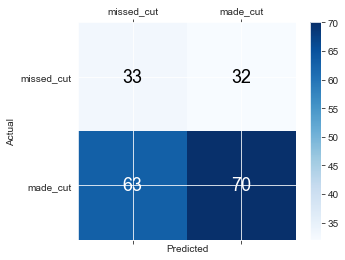

In [96]:
# Instantiate classifier and define model
classifier = DummyClassifier(random_state = SEED)
model_name = 'Dummy Classifier Model'

# Create param grid for GridSearch
param_grid = {
    'strategy' : [
        'stratified', 
        'most_frequent',
        'prior',
        'uniform',
        'constant'
    ]
}

# Instantiate GridSearch
dummy_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dummy_clf.fit(X_train, y_train)
y_hat_pred = dummy_clf.predict(X_train)
y_pred = dummy_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dummy_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

## Logistic Regression

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.7s finished


------------------------------------------------------
Logistic Regression Model Best Params:
------------------------------------------------------
 C : 100000.0
 penalty : l2
 solver : liblinear
------------------------------------------------------
Logistic Regression Model Precision Scores:
------------------------------------------------------
 train:  64.80%
 test:  80.00%
------------------------------------------------------
Logistic Regression Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.47      0.68      0.56        65
    made_cut       0.80      0.63      0.71       133

    accuracy                           0.65       198
   macro avg       0.64      0.65      0.63       198
weighted avg       0.69      0.65      0.66       198

------------------------------------------------------


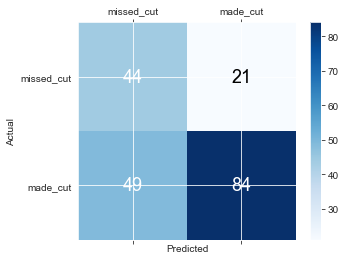

In [97]:
# Instantiate classifier and define model
classifier = LogisticRegression(random_state=SEED)
model_name = 'Logistic Regression Model'

# Create param grid for GridSearch
param_grid = {
    'penalty' : ['l1', 'l2'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'C' : np.logspace(-10, 10, 5),
}

# Instantiate GridSearch
log_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
log_clf.fit(X_train, y_train)
y_hat_pred = log_clf.predict(X_train)
y_pred = log_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = log_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

## KNearest Neighbors (KNN)

Fitting 3 folds for each of 78 candidates, totalling 234 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 234 out of 234 | elapsed:    3.0s finished


------------------------------------------------------
KNN Model Best Params:
------------------------------------------------------
 n_neighbors : 51
 weights : distance
------------------------------------------------------
KNN Model Precision Scores:
------------------------------------------------------
 train:  100.00%
 test:  66.67%
------------------------------------------------------
KNN Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.32      0.43      0.37        65
    made_cut       0.67      0.56      0.61       133

    accuracy                           0.52       198
   macro avg       0.49      0.49      0.49       198
weighted avg       0.55      0.52      0.53       198

------------------------------------------------------


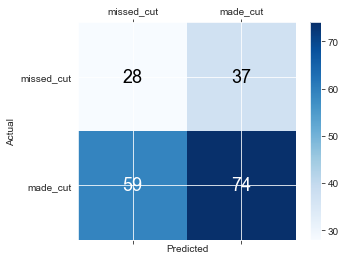

In [99]:
# Instantiate classifier and define model
classifier = KNeighborsClassifier()
model_name = 'KNN Model'

# Create param grid for GridSearch
param_grid = {
    'n_neighbors' : range(3,80,2),
    'weights' : ['uniform', 'distance']
}

# Instantiate GridSearch
knn_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
knn_clf.fit(X_train, y_train)
y_hat_pred = knn_clf.predict(X_train)
y_pred = knn_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = knn_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names = target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

## Decision Tree

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2072 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 3888 out of 3888 | elapsed:   18.5s finished


------------------------------------------------------
Decision Tree Model Best Params:
------------------------------------------------------
 criterion : gini
 max_depth : 3
 min_samples_leaf : 15
 min_samples_split : 5
------------------------------------------------------
Decision Tree Model Precision Scores:
------------------------------------------------------
 train:  72.13%
 test:  86.44%
------------------------------------------------------
Decision Tree Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.41      0.88      0.56        65
    made_cut       0.86      0.38      0.53       133

    accuracy                           0.55       198
   macro avg       0.64      0.63      0.55       198
weighted avg       0.72      0.55      0.54       198

------------------------------------------------------


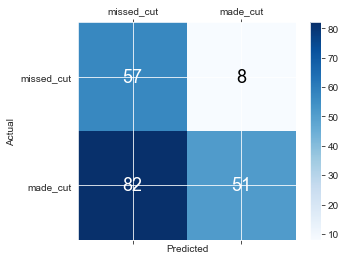

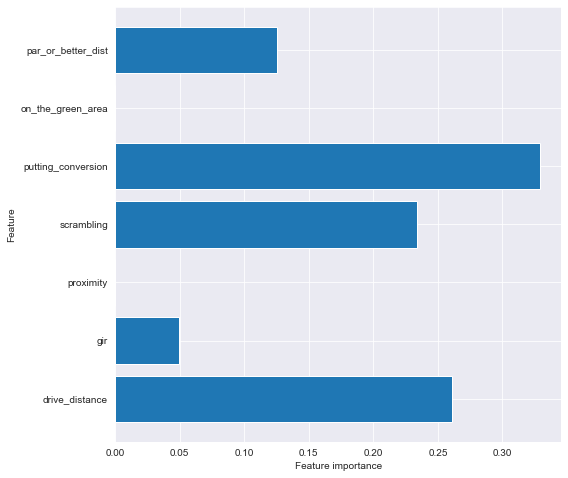

In [100]:
# Instantiate classifier and define model
classifier = DecisionTreeClassifier(random_state=SEED)
model_name = 'Decision Tree Model'

# Create param grid for GridSearch
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(2, 10),
    'min_samples_split' : range(5, 50, 5),
    'min_samples_leaf' : range(5, 50, 5)
}

# Instantiate GridSearch
dt_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dt_clf.fit(X_train, y_train)
y_hat_pred = dt_clf.predict(X_train)
y_pred = dt_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dt_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# feature importance
dt_optimized = DecisionTreeClassifier(
    criterion = best_params['criterion'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    random_state = SEED
)

dt_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features)

## Random Forest

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  3.0min finished


------------------------------------------------------
Random Forest Model Best Params:
------------------------------------------------------
 criterion : gini
 max_depth : 4
 min_samples_leaf : 5
 min_samples_split : 15
 n_estimators : 50
------------------------------------------------------
Random Forest Model F1 Scores:
------------------------------------------------------
 train:  67.02%
 test:  66.67%
------------------------------------------------------
Random Forest Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.46      0.77      0.57        65
    made_cut       0.83      0.56      0.67       133

    accuracy                           0.63       198
   macro avg       0.65      0.66      0.62       198
weighted avg       0.71      0.63      0.64       198

------------------------------------------------------


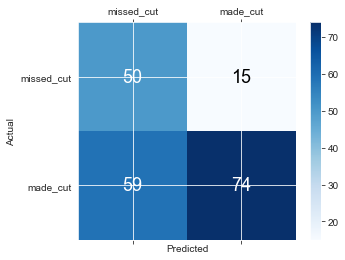

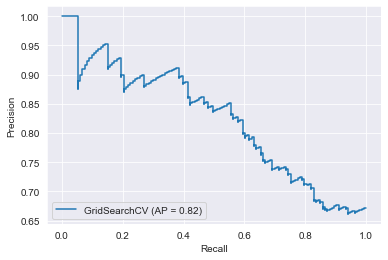

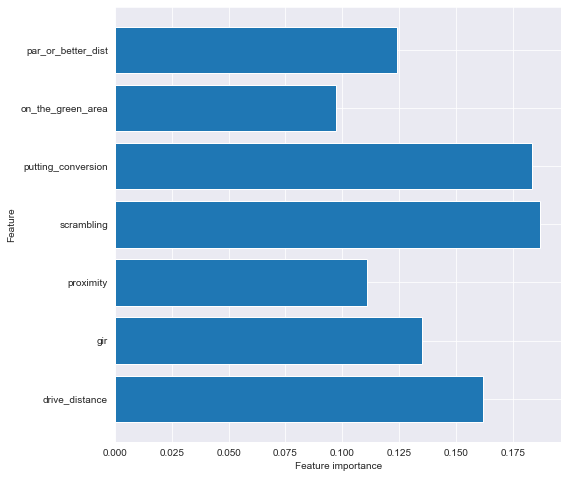

In [101]:
# Instantiate classifier and define model
classifier = RandomForestClassifier(random_state=SEED)
model_name = 'Random Forest Model'

# Create param grid for GridSearch
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : range(50, 450, 50),
    'max_depth' : range(2, 10),
    'min_samples_split' : range(5, 50, 5),
    'min_samples_leaf' : range(5, 50, 5)
}

# Instantiate GridSearch
rf_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
rf_clf.fit(X_train, y_train)
y_hat_pred = rf_clf.predict(X_train)
y_pred = rf_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = rf_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# feature importance
rf_optimized = RandomForestClassifier(
    criterion = best_params['criterion'],
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    random_state = SEED
)

rf_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, rf_optimized, n_features)

## AdaBoost

Fitting 3 folds for each of 171 candidates, totalling 513 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 513 out of 513 | elapsed:  5.7min finished


------------------------------------------------------
AdaBoost Model Best Params:
------------------------------------------------------
 learning_rate : 0.1
 n_estimators : 550
------------------------------------------------------
AdaBoost Model Precision Scores:
------------------------------------------------------
 train:  75.51%
 test:  76.92%
------------------------------------------------------
AdaBoost Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.44      0.63      0.52        65
    made_cut       0.77      0.60      0.68       133

    accuracy                           0.61       198
   macro avg       0.60      0.62      0.60       198
weighted avg       0.66      0.61      0.62       198

------------------------------------------------------


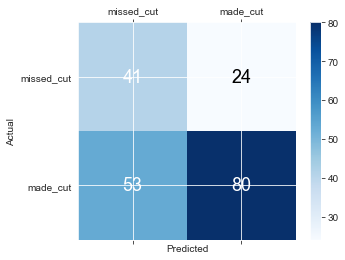

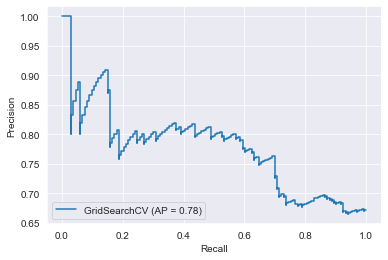

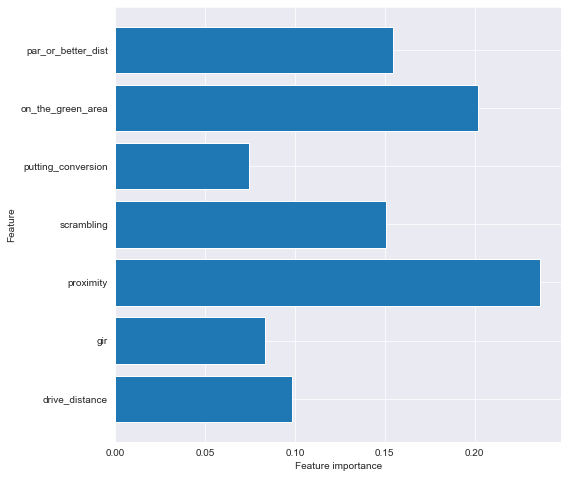

In [109]:
# Instantiate classifier and define model
classifier = AdaBoostClassifier(random_state=SEED)
model_name = 'AdaBoost Model'

# Create param grid for GridSearch
param_grid = {
    'n_estimators' : range(100, 1050, 50),
    'learning_rate' : [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1]
}

# Instantiate GridSearch
ab_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
ab_clf.fit(X_train, y_train)
y_hat_pred = ab_clf.predict(X_train)
y_pred = ab_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = ab_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# # Print Precision-Recall Curve
# disp = metrics.plot_precision_recall_curve(ab_clf, X_test, y_test);

# feature importance
ab_optimized = AdaBoostClassifier(
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    random_state = SEED
)

ab_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, ab_optimized, n_features)

## Gradient Boost

Fitting 3 folds for each of 171 candidates, totalling 513 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 513 out of 513 | elapsed:  4.5min finished


------------------------------------------------------
Gradient Boost Model Best Params:
------------------------------------------------------
 learning_rate : 0.0001
 n_estimators : 350
------------------------------------------------------
Gradient Boost Model Precision Scores:
------------------------------------------------------
 train:  72.59%
 test:  87.72%
------------------------------------------------------
Gradient Boost Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.41      0.89      0.56        65
    made_cut       0.88      0.38      0.53       133

    accuracy                           0.55       198
   macro avg       0.64      0.63      0.54       198
weighted avg       0.72      0.55      0.54       198

------------------------------------------------------


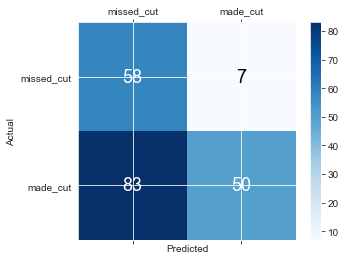

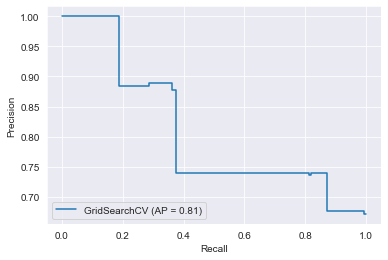

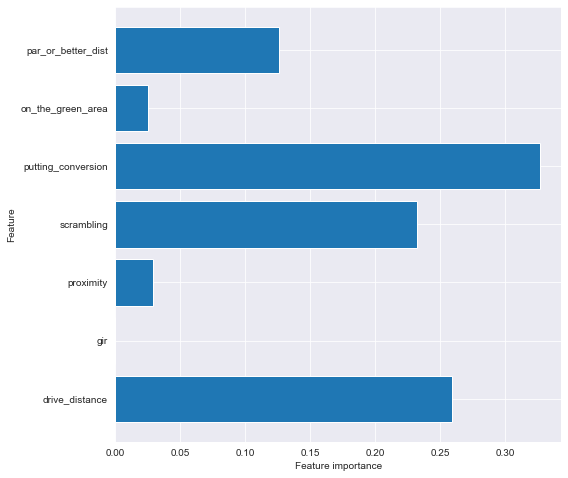

In [108]:
# Instantiate classifier and define model
classifier = GradientBoostingClassifier(random_state=SEED)
model_name = 'Gradient Boost Model'

# Create param grid for GridSearch
param_grid = {
    'n_estimators' : range(100, 1050, 50),
    'learning_rate' : [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1]
}

# Instantiate GridSearch
gb_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
gb_clf.fit(X_train, y_train)
y_hat_pred = gb_clf.predict(X_train)
y_pred = gb_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = gb_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# feature importance
gb_optimized = GradientBoostingClassifier(
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    random_state = SEED
)

gb_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, gb_optimized, n_features)

## Support Vector Machine

In [104]:
# # Instantiate classifier and define model
# classifier = SVC(random_state=SEED)
# model_name = 'Support Vector Machine Model'

# # Create param grid for GridSearch
# param_grid = {
#     'C' : [0.01, 0.1, 1, 10, 100]
#     'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
#     'gamma' : [0.01, 0.1, 1, 10, 100]
# }

# # Instantiate GridSearch
# svm_clf = GridSearchCV(
#     classifier,
#     param_grid,
#     cv=cv,
#     scoring=scoring,
#     verbose=2,
#     n_jobs=-1
# )

# # Fit and make predictions
# svm_clf.fit(X_train, y_train)
# y_hat_pred = svm_clf.predict(X_train)
# y_pred = svm_clf.predict(X_test)

# # Print Best Params
# print('--'*27)
# print(f'{model_name} Best Params:')
# print('--'*27)
# best_params = svm_clf.best_params_
# keys = list(best_params.keys())
# for key in keys:
#     print(f"{key} : {best_params[key]}")

# # Print F1 score
# f1_hat = metrics.f1_score(y_train, y_hat_pred)
# f1 = metrics.f1_score(y_test, y_pred)
# print('--'*27)
# print(f'{model_name} F1 Scores:')
# print('--'*27)
# print(f' Train: {f1_hat : 0.2%}')
# print(f' Test: {f1 : 0.2%}')

# # Print classification report
# print('--'*27)
# print(f'{model_name} Classification Report')
# print('--'*27)
# print(metrics.classification_report(y_test, y_pred, target_names=target_names))
# print('--'*27)

# # Print confusion matrix
# cm = metrics.confusion_matrix(y_test, y_pred)
# classes = target_names
# plot_confusion_matrix(cm, classes)

# # Print Precision-Recall Curve
# disp = metrics.plot_precision_recall_curve(svm_clf, X_test, y_test);

## Result Summary

In [106]:
classifiers = [dummy_clf, log_clf, knn_clf, dt_clf, rf_clf, ab_clf, gb_clf]
names = ['base', 'log_reg', 'knn', 'decTree', 'randomF', 'adaB', 'gradB']
results = []
for index, classifier in enumerate(classifiers):
    result = {}
    y_hat_pred = classifier.predict(X_train)
    y_pred = classifier.predict(X_test)
    result['model'] = names[index]
    result['accuracy'] = round(metrics.accuracy_score(y_test, y_pred)*100,2)
    result['precision'] = round(metrics.precision_score(y_test, y_pred)*100,2)
    results.append(result)

In [105]:
# results_df = pd.DataFrame(results)

# print(results_df.shape)
# results_df

# Predicitons

## Refit Model